# 0. The problem

Source: https://www.kaggle.com/competitions/rossmann-store-sales/overview

## Context

Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.

## Solution

Predict 6 weeks of daily sales for 1115 stores located across Germany. Reliable sales forecasts enable store managers to create effective staff schedules that increase productivity and motivation. By helping Rossmann create a robust prediction model, you will help store managers stay focused on what’s most important to them: their customers and their teams! 

# 1. Data description

**Files**
- train.csv - historical data including Sales
- test.csv - historical data excluding Sales
- store.csv - supplemental information about the stores

**Data fields**
- Id - an Id that represents a (Store, Date) duple within the test set
- Store - a unique Id for each store
- Sales - the turnover for any given day (this is what you are predicting)
- Customers - the number of customers on a given day
- Open - an indicator for whether the store was open: 0 = closed, 1 = open
- StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
- SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
- StoreType - differentiates between 4 different store models: a, b, c, d
- Assortment - describes an assortment level: a = basic, b = extra, c = extended
- CompetitionDistance - distance in meters to the nearest competitor store
- CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
- Promo - indicates whether a store is running a promo on that day
- Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
- Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
- PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

## 1.1. Imports

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set_theme(style="whitegrid")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from pathlib import Path

## 1.2. Loading data

In [59]:
FOLDER_PATH = Path('../data/raw')

In [60]:
df_store = pd.read_csv(filepath_or_buffer=FOLDER_PATH / "store.csv")
df_train_raw = pd.read_csv(filepath_or_buffer=FOLDER_PATH / "train.csv", low_memory=False)
#df_val = pd.read_csv(filepath_or_buffer=FOLDER_PATH / "test.csv")

# 2. Exploratory data analisys

## 2.1. Data description

### 2.1.1. Store

In [61]:
# Information of each store
df_store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [62]:
# Is there any duplicated store?
assert df_store.duplicated(subset=['Store']).sum() == 0

In [63]:
df_store.sample(10)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
683,684,d,c,680.0,NaN,NaN,1,22.0,2012.0,"Jan,Apr,Jul,Oct"
380,381,a,a,1800.0,11.0,2006.0,1,5.0,2013.0,"Feb,May,Aug,Nov"
775,776,c,a,700.0,4.0,2009.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
950,951,d,c,710.0,NaN,NaN,1,40.0,2011.0,"Jan,Apr,Jul,Oct"
587,588,d,c,15720.0,3.0,2010.0,0,NaN,NaN,NaN
57,58,a,c,7340.0,5.0,2008.0,1,27.0,2012.0,"Jan,Apr,Jul,Oct"
557,558,a,a,3000.0,2.0,2010.0,0,NaN,NaN,NaN
118,119,a,c,2100.0,2.0,2010.0,0,NaN,NaN,NaN
337,338,a,c,1590.0,NaN,NaN,1,37.0,2009.0,"Jan,Apr,Jul,Oct"
680,681,a,c,620.0,NaN,NaN,1,1.0,2014.0,"Mar,Jun,Sept,Dec"


In [64]:
df_store["PromoInterval"].value_counts()

PromoInterval
Jan,Apr,Jul,Oct     335
Feb,May,Aug,Nov     130
Mar,Jun,Sept,Dec    106
Name: count, dtype: int64

In [65]:
# When a store is not participating of a continuing promotion, "Promo2SinceWeek", "Promo2SinceYear" and "PromoInterval" have NaN
df_store[["Promo2", "Promo2SinceWeek", "Promo2SinceYear", "PromoInterval"]]

,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,0,NaN,NaN,NaN
1,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,0,NaN,NaN,NaN
4,0,NaN,NaN,NaN
...,...,...,...,...
1110,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1111,0,NaN,NaN,NaN
1112,0,NaN,NaN,NaN
1113,0,NaN,NaN,NaN


In [66]:
df_store.groupby("Promo2")["Promo2SinceWeek"].unique()

Promo2
0                                                [nan]
1    [13.0, 14.0, 1.0, 45.0, 40.0, 26.0, 22.0, 5.0,...
Name: Promo2SinceWeek, dtype: object

In [67]:
df_store.groupby("Promo2")["Promo2SinceYear"].unique()

Promo2
0                                                [nan]
1    [2010.0, 2011.0, 2012.0, 2009.0, 2014.0, 2015....
Name: Promo2SinceYear, dtype: object

In [68]:
df_store.groupby("Promo2")["PromoInterval"].unique()

Promo2
0                                                [nan]
1    [Jan,Apr,Jul,Oct, Feb,May,Aug,Nov, Mar,Jun,Sep...
Name: PromoInterval, dtype: object

**OBS.:**
- StoreType: change to category
- Assortment: change to category
- CompetitionOpenSinceMonth: change to int and add instance month when is NaN
- CompetitionOpenSinceYear: change to int and add instance year when is NaN
- Promo2SinceWeek: fill NaN with zero; change to int
- Promo2SinceYear: fill NaN with zero; change to int
- PromoInterval: fill NaN with zero; there are three intervals, change to a categorical value

StoreType

In [69]:
df_store["StoreType"].value_counts()

StoreType
a    602
d    348
c    148
b     17
Name: count, dtype: int64

Assortment

In [70]:
assortment_map = {"a": "basic",
                  "b": "extra",
                  "c": "extended"}

In [71]:
df_store["Assortment"] = df_store["Assortment"].map(assortment_map)

In [72]:
df_store["Assortment"].value_counts()

Assortment
basic       593
extended    513
extra         9
Name: count, dtype: int64

In [73]:
df_store["Assortment"].isna().sum()

np.int64(0)

CompetitionDistance
- NaN values could be related to a store with no competitors nearby
- Replace NaN with the max distance

In [74]:
df_store[df_store["CompetitionDistance"].isna()]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,basic,NaN,NaN,NaN,0,NaN,NaN,NaN
621,622,a,extended,NaN,NaN,NaN,0,NaN,NaN,NaN
878,879,d,basic,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


In [75]:
df_store["CompetitionDistance"].describe()

count     1112.000000
mean      5404.901079
std       7663.174720
min         20.000000
25%        717.500000
50%       2325.000000
75%       6882.500000
max      75860.000000
Name: CompetitionDistance, dtype: float64

<Axes: xlabel='CompetitionDistance'>

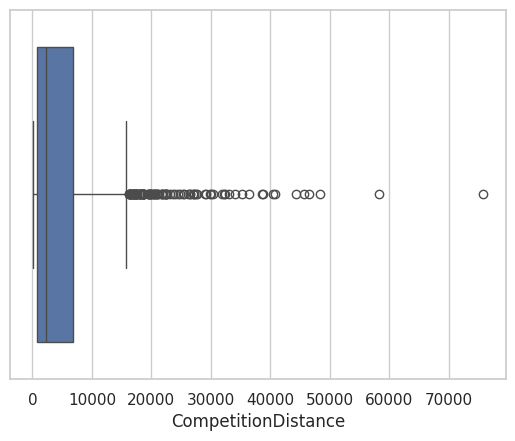

In [76]:
sns.boxplot(data=df_store, x=df_store["CompetitionDistance"])

In [77]:
df_store["CompetitionDistance"] = df_store["CompetitionDistance"].fillna(value=df_store["CompetitionDistance"].max())

In [78]:
df_store["CompetitionDistance"].isna().sum()

np.int64(0)

### 2.1.2. Train

In [79]:
df_train_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


Date

In [80]:
# Convert Date type to datetime
df_train_raw["Date"] = pd.to_datetime(df_train_raw["Date"])

In [81]:
df_train_raw

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1
...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1


StateHoliday

In [82]:
holidays = {"a": "public",
            "b": "easter",
            "c": "xmas",
            "0": "none"}

df_train_raw.loc[:, "StateHoliday"] = df_train_raw["StateHoliday"].map(holidays)

In [83]:
df_train_raw["StateHoliday"].value_counts()

StateHoliday
none      986159
public     20260
easter      6690
xmas        4100
Name: count, dtype: int64

In [84]:
df_train_raw.groupby("StateHoliday")["Open"].value_counts(normalize=True)

StateHoliday  Open
easter        0       0.978326
              1       0.021674
none          1       0.855320
              0       0.144680
public        0       0.965745
              1       0.034255
xmas          0       0.982683
              1       0.017317
Name: proportion, dtype: float64

In [85]:
# There should be no repeated dates for each store
assert df_train_raw.duplicated(subset=["Store", "Date"]).sum() == 0

In [86]:
# Number of instances for each store
df_train_raw.groupby("Store").size().value_counts()

942    934
758    180
941      1
Name: count, dtype: int64

In [87]:
# Closed store has no sales, so it is not relevant
original_shape = df_train_raw.shape
df_train_raw = df_train_raw[df_train_raw["Open"] == 1]
df_train_raw = df_train_raw.drop(columns=["Open"])
print(f"Original shape: {original_shape}")
print(f"New shape: {df_train_raw.shape}")
print(f"Removed lines: {original_shape[0] - df_train_raw.shape[0]}")

Original shape: (1017209, 9)
New shape: (844392, 8)
Removed lines: 172817


### 2.1.3. Join train and store dataframes

In [88]:
df_raw = pd.merge(df_train_raw, df_store, how="left", on="Store")
df_raw.shape

(844392, 17)

## 2.2. Data analisys

CompetitionOpenSinceMonth
- When there is no month, the month of the column Date will be used
- Doing this I am saing the competitor has opened at the some day of the registered sale

In [89]:
df_raw["CompetitionOpenSinceMonth"].isna().sum()

np.int64(268619)

In [90]:
df_raw["CompetitionOpenSinceMonth"] = df_raw["CompetitionOpenSinceMonth"].fillna(value=df_raw["Date"].dt.month)
assert df_raw["CompetitionOpenSinceMonth"].isna().sum() == 0

CompetitionOpenSinceYear
- Same approach from the Month

In [91]:
df_raw["CompetitionOpenSinceYear"].isna().sum()

np.int64(268619)

In [92]:
df_raw["CompetitionOpenSinceYear"] = df_raw["CompetitionOpenSinceYear"].fillna(value=df_raw["Date"].dt.year)
assert df_raw["CompetitionOpenSinceYear"].isna().sum() == 0

Promo2SinceWeek and Promo2SinceYear
- All the missing values occour when Promo2 is zero
- Replace with zero, too

In [93]:
df_raw.groupby("Promo2")["Promo2SinceWeek"].unique()

Promo2
0                                                [nan]
1    [13.0, 14.0, 1.0, 45.0, 40.0, 26.0, 22.0, 5.0,...
Name: Promo2SinceWeek, dtype: object

In [94]:
df_raw.groupby("Promo2")["Promo2SinceYear"].unique()

Promo2
0                                                [nan]
1    [2010.0, 2011.0, 2012.0, 2009.0, 2014.0, 2015....
Name: Promo2SinceYear, dtype: object

In [95]:
df_raw.loc[:, "Promo2SinceWeek"] = df_raw["Promo2SinceWeek"].fillna(value=0)
df_raw.loc[:, "Promo2SinceYear"] = df_raw["Promo2SinceYear"].fillna(value=0)

In [96]:
assert df_raw["Promo2SinceWeek"].isna().sum() == 0
assert df_raw["Promo2SinceYear"].isna().sum() == 0

PromoInterval
- Replace NaN with zero
- Map three intervals corresponding the three groups of month

In [97]:
df_raw.groupby("Promo2")["PromoInterval"].unique()

Promo2
0                                                [nan]
1    [Jan,Apr,Jul,Oct, Feb,May,Aug,Nov, Mar,Jun,Sep...
Name: PromoInterval, dtype: object

In [98]:
df_raw["PromoInterval"].unique()

array([nan, 'Jan,Apr,Jul,Oct', 'Feb,May,Aug,Nov', 'Mar,Jun,Sept,Dec'],
      dtype=object)

In [99]:
df_raw.loc[:, "PromoInterval"] = df_raw["PromoInterval"].fillna(value=0)

In [100]:
promo_intervals = {0: 0,
                   "Jan,Apr,Jul,Oct": 1,
                   "Feb,May,Aug,Nov": 2,
                   "Mar,Jun,Sept,Dec": 3}

df_raw.loc[:, "PromoInterval"] = df_raw["PromoInterval"].map(promo_intervals)

In [101]:
assert df_raw["PromoInterval"].isna().sum() == 0

Changing types

In [102]:
# Changing types
df_raw["CompetitionOpenSinceMonth"] = df_raw["CompetitionOpenSinceMonth"].astype(int)
df_raw["CompetitionOpenSinceYear"] = df_raw["CompetitionOpenSinceYear"].astype(int)
df_raw["Promo2SinceWeek"] = df_raw["Promo2SinceWeek"].astype(int)
df_raw["Promo2SinceYear"] = df_raw["Promo2SinceYear"].astype(int)

In [103]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 844392 entries, 0 to 844391
Data columns (total 17 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   Store                      844392 non-null  int64         
 1   DayOfWeek                  844392 non-null  int64         
 2   Date                       844392 non-null  datetime64[ns]
 3   Sales                      844392 non-null  int64         
 4   Customers                  844392 non-null  int64         
 5   Promo                      844392 non-null  int64         
 6   StateHoliday               844392 non-null  object        
 7   SchoolHoliday              844392 non-null  int64         
 8   StoreType                  844392 non-null  object        
 9   Assortment                 844392 non-null  object        
 10  CompetitionDistance        844392 non-null  float64       
 11  CompetitionOpenSinceMonth  844392 non-null  int64   

In [104]:
num_attributes = ['Store', 'DayOfWeek', 'Sales', 'Customers', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
                  'CompetitionOpenSinceYear', 'Promo2SinceWeek', 'Promo2SinceYear']

In [105]:
df_raw[num_attributes].describe().T

,count,mean,std,min,25%,50%,75%,max
Store,844392.0,558.422920,321.731914,1.0,280.0,558.0,837.0,1115.0
DayOfWeek,844392.0,3.520361,1.723689,1.0,2.0,3.0,5.0,7.0
Sales,844392.0,6955.514291,3104.214680,0.0,4859.0,6369.0,8360.0,41551.0
Customers,844392.0,762.728395,401.227674,0.0,519.0,676.0,893.0,7388.0
CompetitionDistance,844392.0,5640.239545,8580.657735,20.0,710.0,2330.0,6910.0,75860.0
CompetitionOpenSinceMonth,844392.0,6.787346,3.309935,1.0,4.0,7.0,10.0,12.0
CompetitionOpenSinceYear,844392.0,2010.331100,5.502607,1900.0,2008.0,2012.0,2014.0,2015.0
Promo2SinceWeek,844392.0,11.596118,15.307873,0.0,0.0,0.0,22.0,50.0
Promo2SinceYear,844392.0,1003.230065,1005.874806,0.0,0.0,0.0,2012.0,2015.0


<Axes: xlabel='CompetitionOpenSinceYear'>

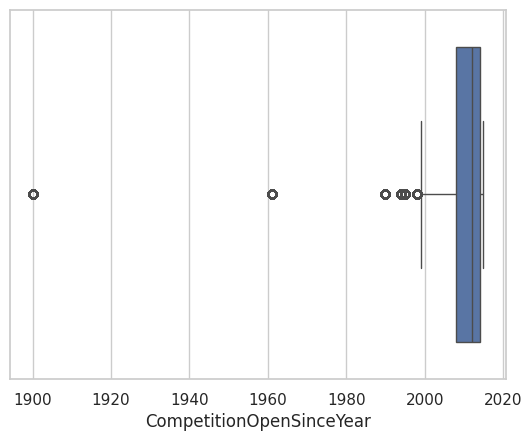

In [106]:
sns.boxplot(df_raw["CompetitionOpenSinceYear"], orient="h")

In [107]:
# Rossmann company was founded in 1972.
# Replace year 1900 by the next min year. Make sense?
comp_open_since_y = df_raw[df_raw["CompetitionOpenSinceYear"] != 1900]["CompetitionOpenSinceYear"].min()
df_raw.loc[df_raw["CompetitionOpenSinceYear"] == 1900, "CompetitionOpenSinceYear"] = comp_open_since_y

In [108]:
df_raw[num_attributes].describe().T

,count,mean,std,min,25%,50%,75%,max
Store,844392.0,558.422920,321.731914,1.0,280.0,558.0,837.0,1115.0
DayOfWeek,844392.0,3.520361,1.723689,1.0,2.0,3.0,5.0,7.0
Sales,844392.0,6955.514291,3104.214680,0.0,4859.0,6369.0,8360.0,41551.0
Customers,844392.0,762.728395,401.227674,0.0,519.0,676.0,893.0,7388.0
CompetitionDistance,844392.0,5640.239545,8580.657735,20.0,710.0,2330.0,6910.0,75860.0
CompetitionOpenSinceMonth,844392.0,6.787346,3.309935,1.0,4.0,7.0,10.0,12.0
CompetitionOpenSinceYear,844392.0,2010.376034,4.806493,1961.0,2008.0,2012.0,2014.0,2015.0
Promo2SinceWeek,844392.0,11.596118,15.307873,0.0,0.0,0.0,22.0,50.0
Promo2SinceYear,844392.0,1003.230065,1005.874806,0.0,0.0,0.0,2012.0,2015.0


Sales

<Axes: xlabel='Sales', ylabel='Count'>

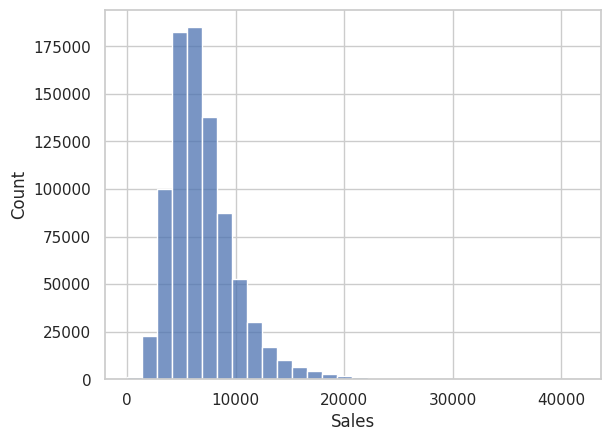

In [109]:
sns.histplot(data=df_raw, x="Sales", bins=30)

Ex: Store 1 year Sales

Text(0.5, 1.0, 'Store 1 daily sales')

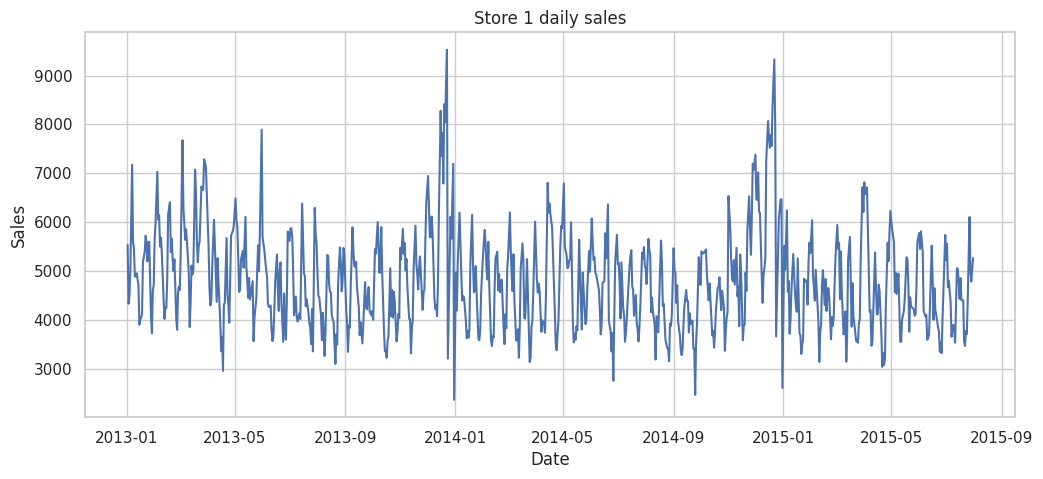

In [110]:
store_n = 1
df_raw_store = df_raw[df_raw["Store"] == store_n][["Date", "Sales"]]
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=df_raw_store, x="Date", y="Sales")
plt.title(f"Store {store_n} daily sales")

**Hypothesis:**

**1.** Stores with extended assortment should sell more. **FALSE**

<Axes: xlabel='Assortment', ylabel='Sales'>

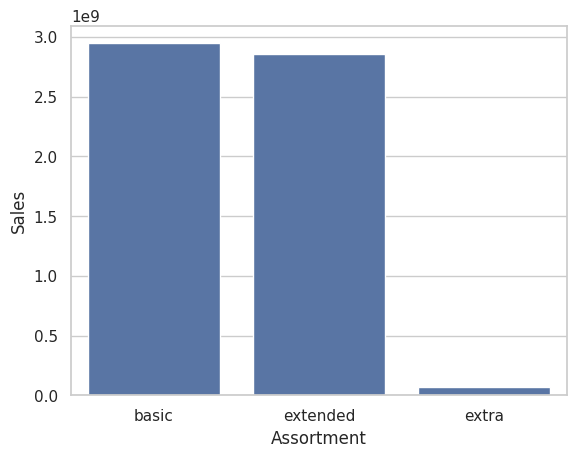

In [111]:
sns.barplot(df_raw.groupby("Assortment")["Sales"].sum())

**2.** Stores with closer competitors should sell less. **FALSE**

In [112]:
hyp2 = df_raw[["CompetitionDistance", "Assortment", "Sales"]]\
    .groupby(["CompetitionDistance", "Assortment"])["Sales"].sum().reset_index()
hyp2

,CompetitionDistance,Assortment,Sales
0,20.0,extended,4579807
1,30.0,basic,13373081
2,30.0,extended,4179585
3,40.0,basic,29261626
4,50.0,basic,20907956
...,...,...,...
790,46590.0,extended,3554993
791,48330.0,basic,3798660
792,58260.0,extended,5718883
793,75860.0,basic,8598547


<Axes: xlabel='CompetitionDistance', ylabel='Sales'>

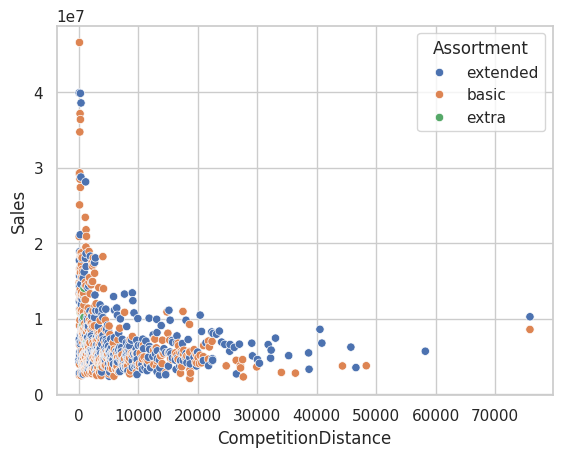

In [113]:
sns.scatterplot(data=hyp2, x="CompetitionDistance", y="Sales", hue="Assortment")

**3.** Stores with long-standing competitors should sell more. **FALSE**

In [114]:
max_year_sales = df_raw.groupby(["Store"])["Date"].max().dt.year.reset_index()
max_year_sales.rename(columns={"Date": "CurrentYear"}, inplace=True)

In [115]:
hyp3 = df_raw[["Store", "CompetitionOpenSinceYear", "Sales"]]\
    .groupby(["Store", "CompetitionOpenSinceYear"])["Sales"].sum().reset_index()

In [116]:
hyp3 = pd.merge(hyp3, max_year_sales, on="Store", how="left")
hyp3["CompetitionOpenedWeeks"] = (hyp3["CurrentYear"] - hyp3["CompetitionOpenSinceYear"]) * 52

In [117]:
hyp3

,Store,CompetitionOpenSinceYear,Sales,CurrentYear,CompetitionOpenedWeeks
0,1,2008,3716854,2015,364
1,2,2007,3883858,2015,416
2,3,2006,5408261,2015,468
3,4,2009,7556507,2015,312
4,5,2015,3642818,2015,0
...,...,...,...,...,...
1818,1114,2014,6227969,2015,52
1819,1114,2015,3809075,2015,0
1820,1115,2013,1694723,2015,104
1821,1115,2014,1985458,2015,52


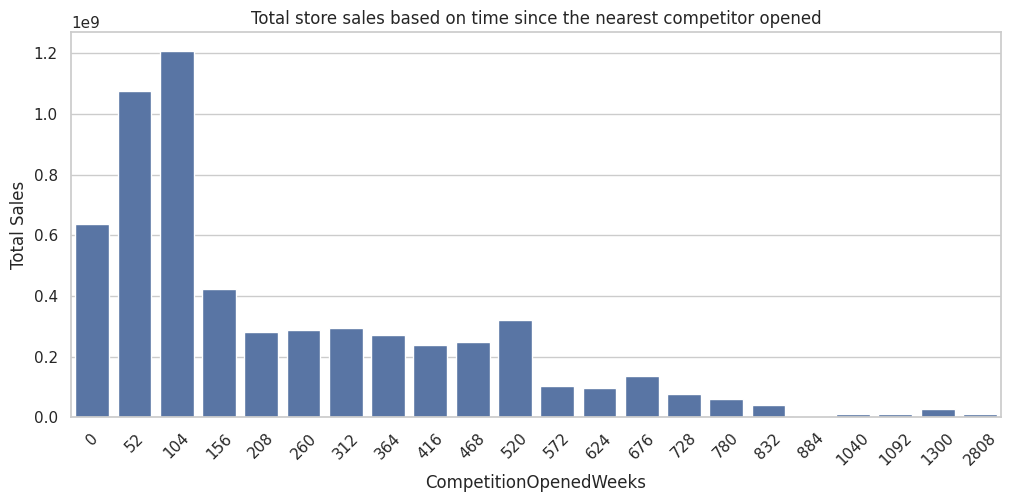

In [118]:
fig, ax = plt.subplots(figsize=(12,5))
sns.barplot(hyp3.groupby("CompetitionOpenedWeeks")["Sales"].sum(), ax=ax)
#sns.barplot(data=hyp3, x="CompetitionOpenedWeeks", y="Sales", ax=ax, errorbar="sd")
plt.title("Total store sales based on time since the nearest competitor opened")
plt.ylabel("Total Sales")
plt.xticks(rotation=45);

**4.** Stores opened in Christmas holiday shoul sell more. **FALSE**

In [119]:
df_raw.groupby("StateHoliday")["Sales"].sum()

StateHoliday
easter       1433744
none      5865164768
public       5890305
xmas          691806
Name: Sales, dtype: int64

In [120]:
hyp4a = df_raw.query("StateHoliday != 'none'").groupby("StateHoliday")["Sales"].sum().reset_index().sort_values(by="Sales")

In [121]:
hyp4b = df_raw[["Date", "StateHoliday", "Sales"]].groupby([df_raw["Date"].dt.year, "StateHoliday"])["Sales"].sum().reset_index()
hyp4b = hyp4b[hyp4b["StateHoliday"] != "none"]

<Axes: xlabel='Date', ylabel='Sales'>

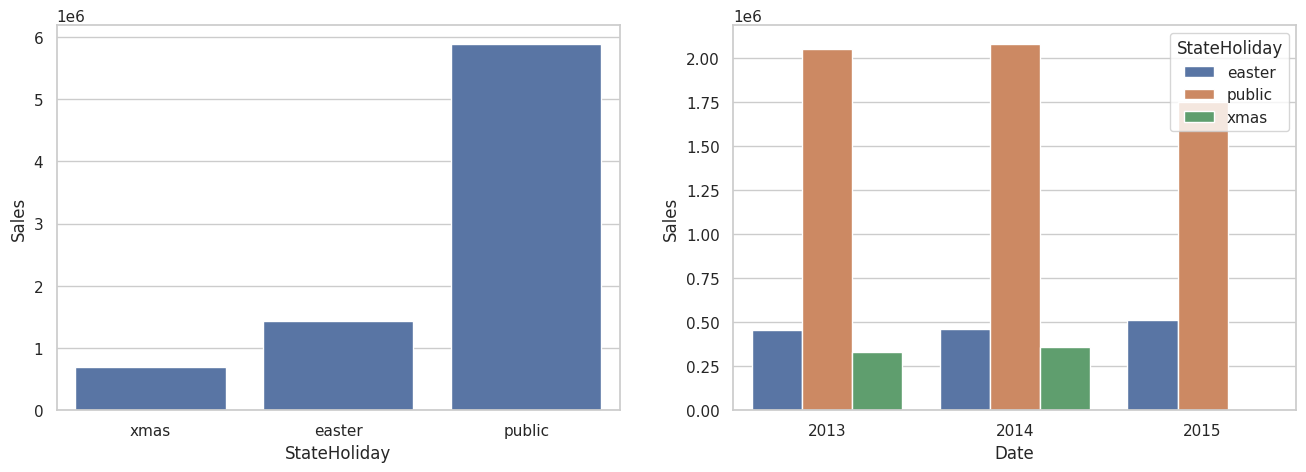

In [122]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,5))
sns.barplot(data=hyp4a, x="StateHoliday", y="Sales", ax=ax[0])
sns.barplot(data=hyp4b, x="Date", y="Sales", hue="StateHoliday", ax=ax[1])

**5.** Stores should sell more over the years. **IN TERMS OF ABSOLUTE VALUES IS FALSE**

In [ ]:
#fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16 ,5))
#sns.barplot(df_raw.groupby(df_raw["Date"].dt.year)["Sales"].mean(), ax=ax[0])
#sns.barplot(df_raw.groupby(df_raw["Date"].dt.year)["Sales"].sum(), ax=ax[1])
#ax[0].set_title("Average sales over the years")
#ax[1].set_title("Total sales over the years")
#ax[0].set_xlabel("Year")
#ax[1].set_xlabel("Year")
#ax[0].set_ylabel("Average Sales")
#ax[1].set_ylabel("Total Sales")

In [123]:
hyp5 = df_raw[["Date", "Sales"]]
hyp5["Year"] = hyp5["Date"].dt.year
hyp5.drop(columns="Date", inplace=True)
hyp5

/tmp/ipykernel_132963/330601848.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hyp5["Year"] = hyp5["Date"].dt.year
/tmp/ipykernel_132963/330601848.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hyp5.drop(columns="Date", inplace=True)


,Sales,Year
0,5263,2015
1,6064,2015
2,8314,2015
3,13995,2015
4,4822,2015
...,...,...
844387,3375,2013
844388,10765,2013
844389,5035,2013
844390,4491,2013


Text(0, 0.5, 'Total Sales')

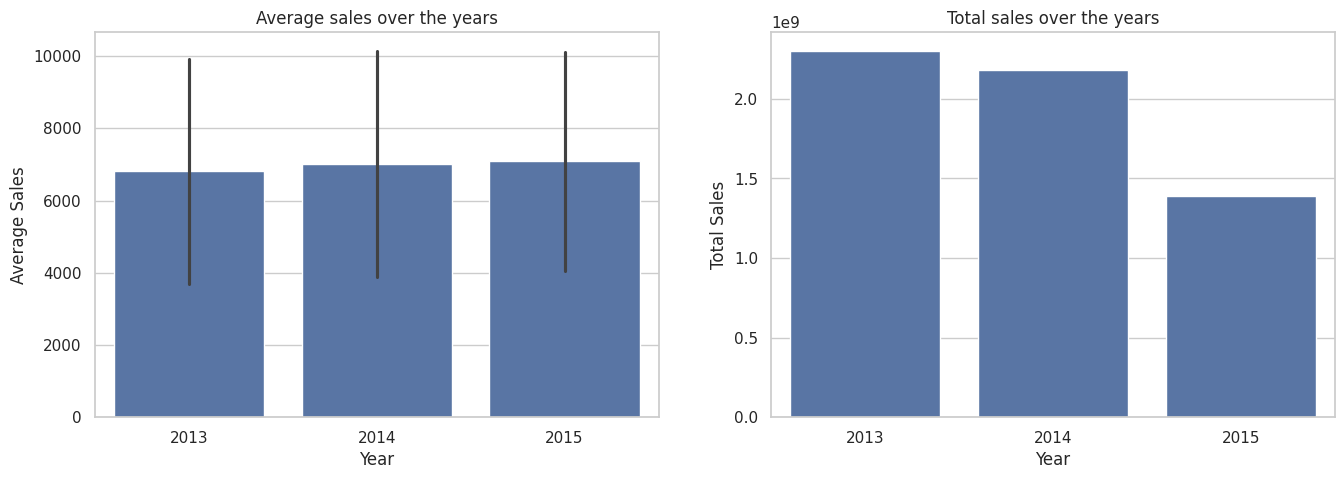

In [124]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16 ,5))
sns.barplot(data=hyp5, x="Year", y="Sales", estimator="mean", errorbar="sd", ax=ax[0])
sns.barplot(data=hyp5, x="Year", y="Sales", estimator="sum", errorbar="sd", ax=ax[1])
ax[0].set_title("Average sales over the years")
ax[1].set_title("Total sales over the years")
ax[0].set_xlabel("Year")
ax[1].set_xlabel("Year")
ax[0].set_ylabel("Average Sales")
ax[1].set_ylabel("Total Sales")

**6.** Stores should sell more in the second half of the year. **FALSE**

In [125]:
hyp6a = df_raw.groupby([df_raw["Date"].dt.year, df_raw["Date"].dt.month])[["Sales"]].sum()
hyp6a.index.names = ["Year", "Month"]
hyp6a = hyp6a.reset_index()

/home/ezequielpf/Documentos/Projetos_Data_Science/rossmann_sales_prediction/venv_rossman/lib/python3.11/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


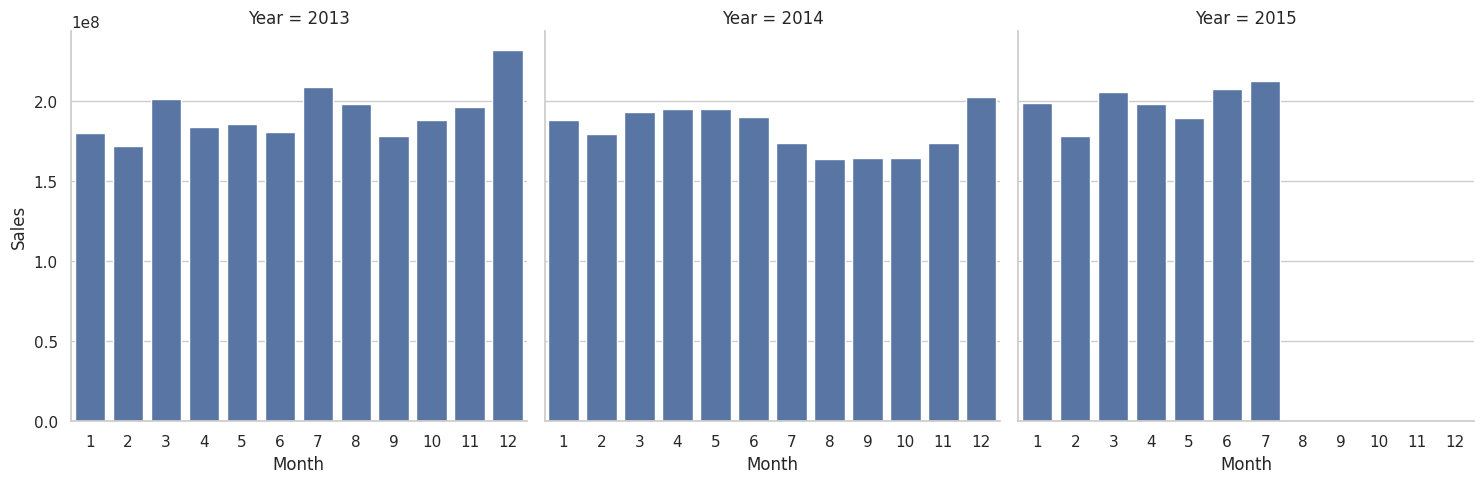

In [126]:
fig = sns.FacetGrid(data=hyp6a, col="Year", sharey=True, height=5)
fig.map(sns.barplot, "Month", "Sales")

In [127]:
hyp6a["Sem"] = hyp6a["Month"].apply(lambda x: 1 if x <= 6 else 2)

<Axes: xlabel='Sem', ylabel='Sales'>

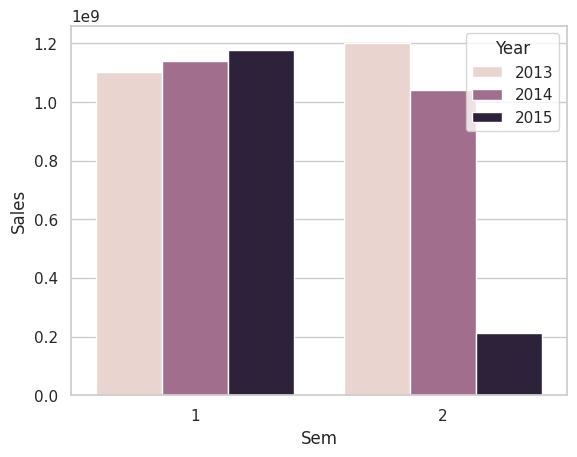

In [128]:
sns.barplot(data=hyp6a.groupby(["Year", "Sem"])["Sales"].sum().reset_index(), x="Sem", y="Sales", hue="Year")

**7.** Stores should sell less on weekends. **FALSE**

In [ ]:
#fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,5))
#sns.barplot(data=df_raw.groupby("DayOfWeek")["Sales"].mean().reset_index(), x="DayOfWeek", y="Sales", ax=ax[0])
#sns.barplot(data=df_raw.groupby("DayOfWeek")["Sales"].sum().reset_index(), x="DayOfWeek", y="Sales", ax=ax[1])
#ax[0].set_title("Daily average sales")
#ax[1].set_title("Daily total sales")
#ax[0].set_xlabel("Year")
#ax[1].set_xlabel("Year")
#ax[0].set_ylabel("Average Sales")
#ax[1].set_ylabel("Total Sales")
##ax[0].set_xticks([1,2,3,4,5,6,7])
#ax[0].set_xticklabels(["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"])
##ax[1].set_xticks([1,2,3,4,5,6,7])
#ax[1].set_xticklabels(["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"]);

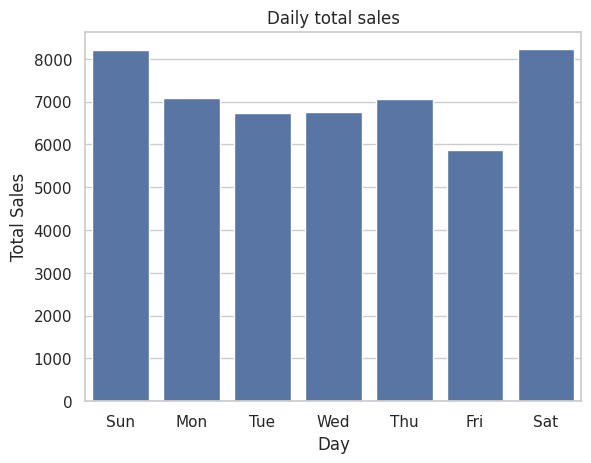

In [129]:
sns.barplot(data=df_raw.groupby("DayOfWeek")["Sales"].mean().reset_index(), x="DayOfWeek", y="Sales")
plt.title("Daily total sales")
plt.xlabel("Day")
plt.ylabel("Total Sales")
plt.xticks(ticks=[0,1,2,3,4,5,6], labels=["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"]);

**8.** Stores should sell less during school holidays. **TRUE FOR TOTAL SALES**

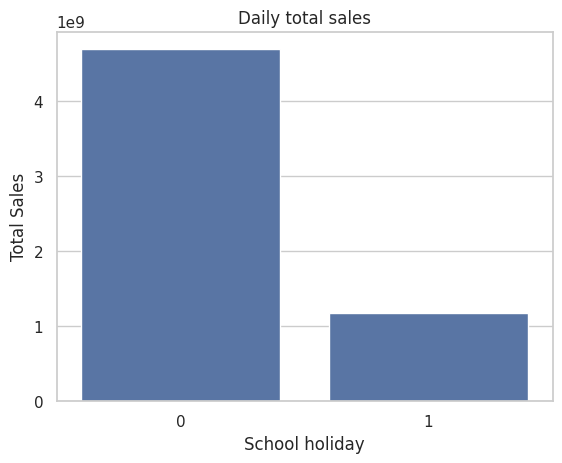

In [130]:
sns.barplot(data=df_raw.groupby("SchoolHoliday")["Sales"].sum().reset_index(), x="SchoolHoliday", y="Sales")
plt.title("Daily total sales")
plt.xlabel("School holiday")
plt.ylabel("Total Sales");

# 3. Data preparation

## 3.1. Changing data types

In [131]:
df_raw["PromoInterval"] = df_raw["PromoInterval"].astype(dtype="category")
df_raw["Promo"] = df_raw["Promo"].astype(dtype="category")
df_raw["SchoolHoliday"] = df_raw["SchoolHoliday"].astype("category")
df_raw["Promo2"] = df_raw["Promo2"].astype("category")

## 3.2. Feature creation

In [132]:
def CreateLagFeature(df):
    for lag in [7, 14, 28]:
        df[f"Sales_lag_{lag}"] = df.sort_values(by=["Store", "Date"]).groupby("Store")["Sales"].shift(lag)
    return df

In [133]:
def CreateRollingMeanFeature(df):
    for window in [7, 14, 28]:
        df[f"Sales_roll_mean_{window}"] = df.sort_values(by=["Store", "Date"])["Sales"].rolling(window=window, closed="left").mean()
    return df

In [134]:
def FeatureCreation(df):
    df["DayOfYear"] = df["Date"].dt.day_of_year
    df["Year"] = df["Date"].dt.year
    df["QuarterOfYear"] = df["Date"].dt.quarter
    df["Month"] = df["Date"].dt.month
    df["WeekOfYear"] = df["Date"].dt.isocalendar().week
    df = CreateLagFeature(df)
    df = CreateRollingMeanFeature(df)
    df.dropna(inplace=True)
    return df

In [135]:
df_raw = FeatureCreation(df_raw)

Text(0.5, 1.0, 'Store 1 daily sales')

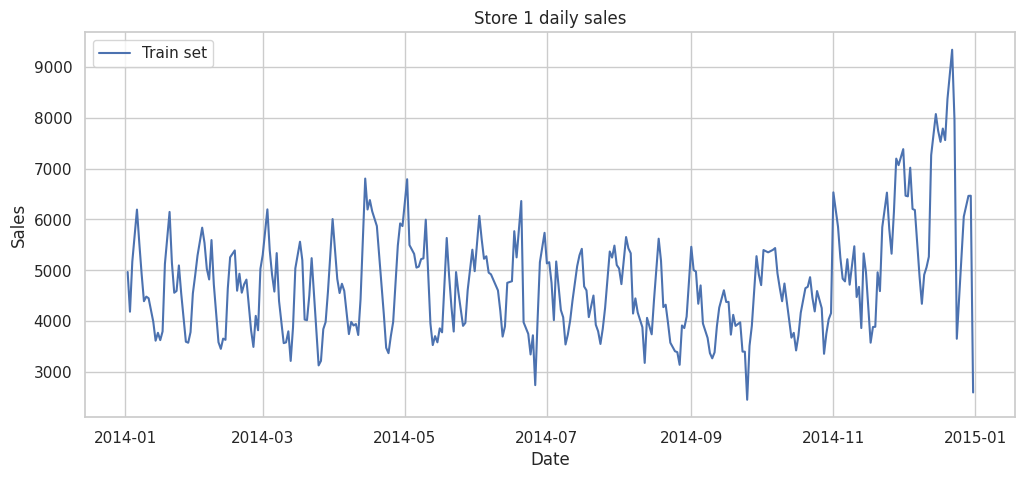

In [136]:
store_n = 1
year = 2014
df_raw_store = df_raw[(df_raw["Store"] == store_n) & (df_raw["Date"].dt.year == year)][["Date", "Sales"]]
#df_test_store = df_test[df_test["Store"] == store_n & df_raw["Date"].dt.year == year][["Date", "Sales"]]
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=df_raw_store, x="Date", y="Sales", label="Train set")
#sns.lineplot(data=df_test_store, x="Date", y="Sales", label="Test set")
plt.title(f"Store {store_n} daily sales")

Text(0.5, 1.0, 'Store 1 daily sales')

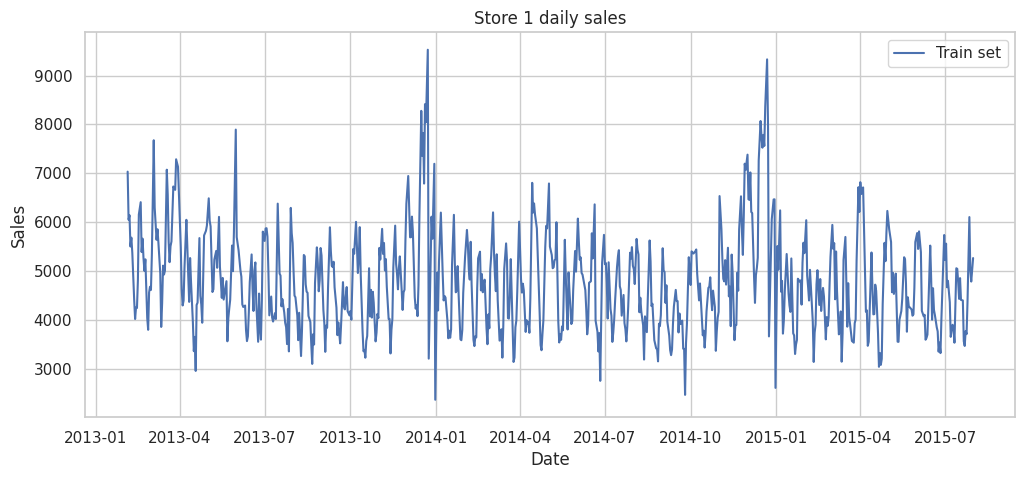

In [137]:
store_n = 1
df_raw_store = df_raw[df_raw["Store"] == store_n][["Date", "Sales"]]
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=df_raw_store, x="Date", y="Sales", label="Train set")
plt.title(f"Store {store_n} daily sales")

## 3.3. Encoding

### StateHoliday

In [138]:
ohe_stt_hld = OneHotEncoder(sparse_output=False, dtype="int").set_output(transform="pandas")
stt_hld = ohe_stt_hld.fit_transform(df_raw[["StateHoliday"]])
df_raw = pd.concat(objs=[df_raw, stt_hld], axis="columns").drop(columns="StateHoliday")

### StoreType

In [139]:
ohe_sto_typ = OneHotEncoder(sparse_output=False, dtype="int").set_output(transform="pandas")
sto_typ = ohe_sto_typ.fit_transform(df_raw[["StoreType"]])
df_raw = pd.concat(objs=[df_raw, sto_typ], axis="columns").drop(columns="StoreType")

### Assortment

In [140]:
ohe_assort = OneHotEncoder(sparse_output=False, dtype="int").set_output(transform="pandas")
assort = ohe_assort.fit_transform(df_raw[["Assortment"]])
df_raw = pd.concat(objs=[df_raw, assort], axis="columns").drop(columns="Assortment")

## 3.4. Scaling

In [141]:
lag_rolling_features = [col for col in df_raw.columns if "Sales_lag" in col or "Sales_roll" in col]

In [142]:
std_scaler = StandardScaler()
df_raw[lag_rolling_features] = std_scaler.fit_transform(df_raw[lag_rolling_features])

**Skip for now**

## 3.5. Train-test split

- It is necessary to set aside the last 6 registered weeks of each store for testing

In [143]:
def split_store_data(df, test_size=6*7):
    stores = df["Store"].unique()
    train_list = []
    test_list = []

    for store in stores:
        store_data = df[df["Store"] == store].sort_values(by="Date")
        train, test = train_test_split(store_data, test_size=test_size, shuffle=False)
        train_list.append(train)
        test_list.append(test)

    df_train = pd.concat(train_list)
    df_test = pd.concat(test_list)
    
    return df_train, df_test

In [144]:
df_train, df_test = split_store_data(df=df_raw, test_size=6*7)

In [145]:
df_train.shape, df_test.shape

((766342, 36), (46830, 36))

In [146]:
# Check data splitting
assert df_train.shape[0] + df_test.shape[0] == df_raw.shape[0], "Problem in data splitting"

In [147]:
stores = df_store["Store"].unique()
for store in stores:
    assert df_train[df_train["Store"] == store]["Date"].max() < df_test[df_test["Store"] == store]["Date"].min(), \
        "Minimum test data is earlier than maximum train data"

In [148]:
df_test.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Promo',
       'SchoolHoliday', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval', 'DayOfYear', 'Year',
       'QuarterOfYear', 'Month', 'WeekOfYear', 'Sales_lag_7', 'Sales_lag_14',
       'Sales_lag_28', 'Sales_roll_mean_7', 'Sales_roll_mean_14',
       'Sales_roll_mean_28', 'StateHoliday_easter', 'StateHoliday_none',
       'StateHoliday_public', 'StateHoliday_xmas', 'StoreType_a',
       'StoreType_b', 'StoreType_c', 'StoreType_d', 'Assortment_basic',
       'Assortment_extended', 'Assortment_extra'],
      dtype='object')

## 3.6. Saving processed data

In [150]:
SAVING_PATH = Path("../data/processed")

df_train.to_csv(SAVING_PATH / "train.csv", index=False)
df_test.to_csv(SAVING_PATH / "test.csv", index=False)

Text(0.5, 1.0, 'Store 1 daily sales')

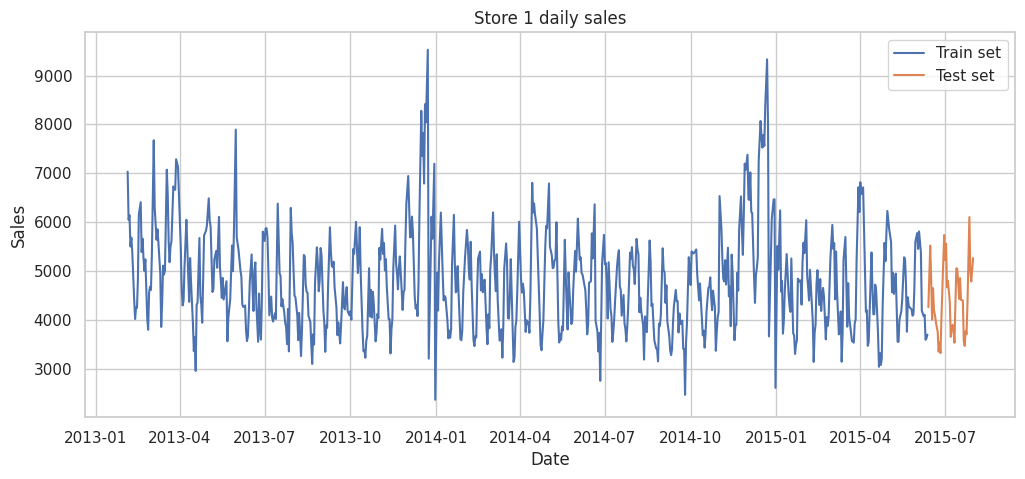

In [149]:
store_n = 1
df_train_store = df_train[df_train["Store"] == store_n][["Date", "Sales"]]
df_test_store = df_test[df_test["Store"] == store_n][["Date", "Sales"]]
fig, ax = plt.subplots(figsize=(12,5))
sns.lineplot(data=df_train_store, x="Date", y="Sales", label="Train set")
sns.lineplot(data=df_test_store, x="Date", y="Sales", label="Test set")
plt.title(f"Store {store_n} daily sales")